In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import os 
import site
import sys
import warnings

from google.colab import files
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None                                        # suppress SettingWithCopy warning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)                        # df.append will be deprecated, need to replace with pd.concat throughout

### Functions

In [ ]:
def C_calc(t, x):
    """This calculates the concentration vs time - breakthrough curve (BTC) - for
    any given set of models

    It can be called to return the BTC at the observation point by passing t_obs
    and x_obs
    It can be called to return the BTC at the point of compliance by passing
    t_pred and x_pred

    initial_C is the initial concentration input by user at top of code and is
    held constant for all models
    pulse_time is the point sources release input by user at top of code and is
    held constant for all models

    R, D, Lambda, and v are the model parameters - these are varied to explore
    parameter space when forming the ensembles

    returns: ndarray of concentrations vs time for an ensemble that is defined by
    an ndarray of parameter values   
    """
    C_array = np.zeros((np.shape(t)[0], np.shape(R)[0]))
    for i in range(len(R)):
        C_array[:,i] = ((initial_c*pulse_time*x*R[i]**.5)/
        (2*(math.pi*D[i]*(t**3))**.5))*\
        np.exp(-((R[i]*x-v[i]*t)**2)/(4*R[i]*D[i]*t))*\
        np.exp(-Lambda[i]*t)

        C_array[np.where(C_array<0)]=0
        C_array[np.where(np.isinf(C_array)==1)]=0
        C_array[np.where(np.isnan(C_array)==1)]=0
    return C_array

def normalize_params(array_name):
    """This normalizes the parameters R, D, Lamda, v for any given set of models
    by each parameter's min and max values
        
    It can be called to return a normalized array by passing an array of model
    parameters  
    
    returns: ndarray of normalized parameters for the given set of models
    """
    normed_array = (array_name - Pmin_array)/(Pmax_array - Pmin_array)
    return normed_array

def distance_good(array_normed1, array_normed2, df_update):
    """This calculates the minimum distance in parameter space between the best-
    fitting model in an ensemble and any given set of models
    
    It can be called to return the closest model by passing the normalized
    ensemble array and a second normalized array

    returns: dataframe containing parameters of the single closest model
    """
    this_distance = np.sqrt(np.sum(((array_normed1 - array_normed2)**2), axis = 1))
    df_update.dist = this_distance
    df_update = df_update.loc[df_update.groupby('dist').dist.idxmin()]\
                    .reset_index(drop=True)
    df_update.good_model[0] = 1                                                  
    metrop_close = df_update[df_update.good_model == 1]
    return metrop_close

def plot_Censemble():
    """This plots the concentration vs time - breakthrough curve (BTC) for the 
    best-fit ensemble

    It can be called to return a BTC plot, and does not require an input
    
    ensemble_size is the number of models in ensemble input by user at top of code
    t_obs is the number of data points at the observation point input by user at
    top of code and is held constant for all models
    
    returns: a 2D plot showing the BTC of each model in the best-fit ensemble
    """
    for i in np.arange(ensemble_size):
    #    labelstr='model ' + str(i+1)
    #    plt.plot(t_obs, C_ensemble[:,i],label=labelstr)
      plt.plot(t_obs, C_ensemble[:,i])

    plt.plot(t_obs, C_true,'p', markersize = 3, label='Truth model', color = 'black', lw = 2)
    plt.rcParams['figure.facecolor'] = 'white'
    plt.xlabel('Time (days)')
    plt.ylabel('Concentration (mg/L)')
    plt.title('Best-fit Ensemble at Observation Point') 
    plt.legend()
    plt.rcParams["figure.figsize"] = (10,6)
  
    plt.show()
    return plt.plot()  

def plot_CMOC_pred():
    """This plots the predicted concentration vs time - breakthrough curve (BTC) -
    for the MOC ensemble

    It can be called to return a BTC plot and does not require an input
    
    ensemble_size is the number of models in ensemble input by user at top of code
    t_pred is the number of data points at the point of compliance input by user
    at top of code and is held constant for all models
    
    returns: a 2D plot showing the predicted BTC of each model in the MOC ensemble
    """

    for i in np.arange(ensemble_size):
    #    labelstr='model ' + str(i+1)
    #    plt.plot(t_pred, C_MOC_ensemble_pred[:,i],label=labelstr)
      plt.plot(t_pred, C_MOC_ensemble_pred[:,i])
    #plt.axhline(y=C_0, color = 'gray', label = 'Utility cutoff')
    #plt.plot(t_obs, C_true,'p', markersize = 3, label='Data w/error', color = 'black', lw = 2)
    plt.rcParams['figure.facecolor'] = 'white'
    plt.xlabel('Time (days)')
    plt.ylabel('Concentration (mg/L)')
    plt.title('MOC Ensemble Prediction') 
    plt.legend()
    plt.rcParams["figure.figsize"] = (10,6)
    plt.show()
    return plt.plot()

### Variables

In [ ]:
# These variables dictate the total number of parameter sets, the number in an ensemble,
# and how many to replace
ensemble_size = 200 #40
num_replace_different = 2                                                         # number of ensemble models to be replaced in each round
num_replace_good = 1                                                              # number of metropolis models to run because they are close to the best ensemble model
metropolis_rounds = 10 #20
Pnum = 8000 #4000                                                                 # number of parameter sets to consider (size of sampled world)
trials = Pnum/ensemble_size - metropolis_rounds                                   # number of iterations to sample metropolis models
the_seed = 1                                                                      # dictates ensemble models are repeatable AND different from truth models
rounds = 1                                                                        # number of different ensembles to run per each truth round. PLACEHOLDER because removing this 'x' loop gives a shape index error.

# These variables determine the number of truth models to generate
truth_num = 1 #5 #10                                                              # a dimension for created truth model dataframe
truth_seed = 1 #2=truth not MOC  #1=truthMOC #4=original for truth matrix                                                                      # assign the seed for reproduceable random values
truth_rounds = 1 #10 #500                                                        

# These are constants used in the transport equation to calculate the breakthrough curve of each model
initial_c = 1                                                                     # source concentration                                                      
x_obs = 200                                                                       # distance from source to sentry well
x_pred = 1000                                                                     # distance from source to point of compliance
pulse_time = 127                                                                  # duration of point source release
t_start = 0            
t_end = 200                                                                       # days of observed concentration
t_end_pred = 1000                                                                 # days of calculated predictions
dt = 10
meas_error_percent = 0                                                            # add random relative error, zero mean                                                                    

# These are user defined thresholds for weighing model utility
U_th = .16                                                                        # utility threshold: models with utility < U_th are models of concern (MOC)
C_0 = .24                                                                         # concentration level above which a model will have zero utility
C_1 = .005                                                                        # concentration level below which a model will have highest utility 
probability_MOC = .5

# These variables describe how many models to consider and replace in the MOC ensemble
MOC_size = 20                                                                     # Variables for Round 2: MOC_ensemble size
len_R1R2 = ensemble_size + MOC_size                                               # append len_R1R2 number of zeros to hold_R1R2_cumulative_L_c when R2 has insufficient MOCs
num_close = 1                                                                     # number of metropolis models to run because they are close to the best ensemble model
num_far = 1                                                                       # number of metropolis models to run because they are different from all sampled
new_rounds = 10                                                                   # number of metropolis to sample each iteration
MOCtrials = 10

t_obs = np.arange(t_start, t_end,dt)                                              # number of timesteps (days)
t_pred = np.arange(t_start, t_end_pred,dt)

# These create the structure of parameter space, where all potential parameter sets are held
Params1 = ('v', 'D', 'Lambda', 'R','xsampled')                                    # velocity, dispersion, lambda, retardation, columns for each model
Plims=pd.DataFrame([[1,3],[10,100],[0,.005],[1,2],[0,0]])                         # parameter limits
Plims.index = Params1
Plims.columns = ('minval','maxval')
Params = ('v', 'D', 'Lambda', 'R','xsampled','xID')
Plims_array = Plims.to_numpy()                                                    # Plims to array for normalizing
Pmin_array = Plims_array[0:4,0]
Pmax_array = Plims_array[0:4,1]

R1_seed_util = np.zeros(shape=(ensemble_size,truth_rounds))
R1_seed_util = pd.DataFrame(R1_seed_util)
R1R2_seed_util = np.zeros(shape=(0,truth_rounds))
R1R2_seed_util = pd.DataFrame(R1R2_seed_util)

# columns = len(truth_rounds)

### Generate all truth models
##### This creates a dataframe of all truth models then calculates the concentration vs time - breakthrough curve (BTC) - for each model at the point of observation and at the point of compliance

In [ ]:
np.random.seed(truth_seed)
truth_model = pd.DataFrame(np.random.rand(truth_rounds,Plims.shape[0]+1),columns=Params)     
truth_model = truth_model * (Plims.maxval-Plims.minval) + Plims.minval      
truth_model['ID']=np.arange(truth_rounds)               
truth_model['C_0'] = C_0
truth_model['Cmax'] = -1                                                           
truth_model['Utotal'] = 99   
truth_model['goodRMSE'] = 99        
truth_model['goodUtotal'] = 99                                           

D = truth_model.D.to_numpy()                                               
Lambda = truth_model.Lambda.to_numpy()
R = truth_model.R.to_numpy()
v = truth_model.v.to_numpy()                                        
C_truth = C_calc(t_obs, x_obs)                                                  
C_truth_pred = C_calc(t_pred, x_pred)                                           

C_error = (np.random.rand(t_obs.shape[0])-0.5)*meas_error_percent/100
C_error = np.expand_dims(C_error, axis=-1)
C_truth = C_truth + C_error                                                    

truth_model.Cmax = C_truth_pred.max(axis = 0)                                   
truth_model.Utotal = 1-((truth_model.Cmax - C_1) / (C_0 - C_1))                
truth_model.Utotal[truth_model.Cmax > C_0] = 0                                  
truth_model.Utotal[truth_model.Cmax < C_1] = 1                                  
truth_model.insert(0, 'U_th', U_th)                                             
truth_model.insert(1, 'MOC', 0)                                                 
truth_model.MOC[truth_model.Utotal < U_th] = 1                                    
truth_model.drop(['xsampled', 'xID'], axis=1, inplace=True)      

#truth_model = truth_model.tail(1)      #run for a single FP truth model    
#download csv of truth models
#truth_model.to_csv('unsorted33_truths.csv') 
#files.download('unsorted33_truths.csv')     

# HOLDING ARRAYS
hold_1D_truth = truth_model.MOC.to_numpy()                                      
hold_MOCprob_round1 = np.zeros(truth_rounds)                                   
hold_MOCprob_R1R2 = np.zeros(truth_rounds)                                     
hold_max_MOCprob_round1 = np.zeros(truth_rounds)                                 
hold_max_MOCprob_R1R2 = np.zeros(truth_rounds)
hold_failed_runs = np.zeros(truth_rounds)                                      

hold_good_RMSE = np.zeros(0)           # hold the best model from each ensemble iteration
hold_good_Utotal = np.zeros(0)

hold_ens_RMSE = np.zeros(0)            # hold full ensemble from all ensemble iterations
hold_ens_Utotal = np.zeros(0)
hold_ens_Cmax = np.zeros(0)

print(hold_1D_truth)

[1]


### Ensemble Calculations
##### This creates a parameter space of all sets of parameters to be explored. First, a best-fit ensemble is formed. Then, new models are iteratively considered and included if having a better fit to the observation data. 
##### A second 'MOC-ensemble' is compiled exclusively of models of concern (MOC). Then, new models are iteratively considered and included in the MOC-ensemble if they have a better fit to the observation data AND are MOCs. 
##### Finally, the two ensembles are combined and assessed for the probability of an adverse outcome.

truth model 0
rmse array
[0.         0.36201294 0.22648555 0.52017986 0.50439596 0.4236647
 0.06098714 0.14603434 0.45309865 0.31227467 0.37164256 0.20823739
 0.18903283 0.17891877 0.32093012 0.29192317 0.16317899 0.17920227
 0.3134647  0.42599095 0.49307292 0.11550015 0.34900659 0.36441206
 0.51970157 0.25361212 0.42334614 0.33988305 0.25754802 0.16136209
 0.25030553 0.38897963 0.24601367 0.22214565 0.25784199 0.17084259
 0.28713435 0.36442609 0.13695045 0.14549644 0.18766951 0.48099011
 0.27394374 0.37767038 0.17713061 0.25395223 0.39352798 0.31507386
 0.19897139 0.30076689 0.15299977 0.26500913 0.42879927 0.2551111
 0.19181268 0.25812278 0.27493152 0.06047537 0.39091757 0.17693824
 0.4211315  0.44388643 0.17389896 0.26649994 0.36646273 0.14520934
 0.2064462  0.42263655 0.38156145 0.16185238 0.38923862 0.37675734
 0.20017403 0.48497713 0.16678643 0.43600028 0.40033554 0.37241102
 0.20714977 0.41686454 0.26424794 0.43938565 0.40638678 0.47465206
 0.15930303 0.17869626 0.42666479 0.528

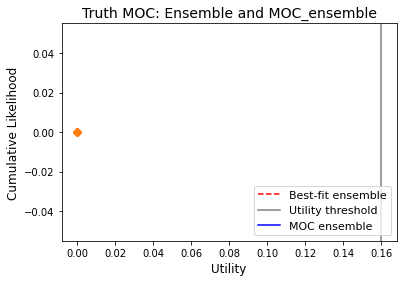

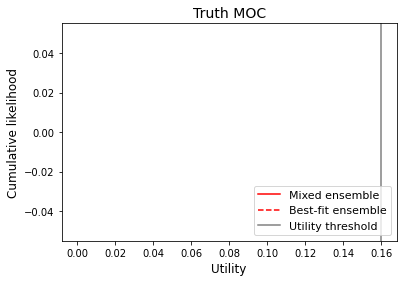

In [ ]:
#threshold_columns = ['C_0', 'C_1', 'U_th', 'diff_L_c']
#thresholds = pd.DataFrame(columns=threshold_columns, index=[0])
#thresholds[0:1] = C_0, C_1, U_th, 0

everything = []
more_everything = []
single_thresholds = []
diff_threshold = .07

iterate_threshold = 1
for s in range(iterate_threshold):
  C_0 = C_0
  for x in range(truth_rounds):
    print('truth model', x)
    #print(D[x],Lambda[x],R[x], v[x]) #index error for first truth_MOC

    np.random.seed(the_seed)                                                              
    Pspace = pd.DataFrame(np.random.rand(Pnum,Plims.shape[0]+1),columns=Params)
    Pspace = Pspace * (Plims.maxval-Plims.minval) + Plims.minval                    
    Pspace.xsampled=0                                                               
    Pspace.xID=np.arange(Pnum)                                                      
    Pspace['good_model'] = 0                                                        
    Pspace['RMSE'] = 0
    Pspace['dist'] = 0                                                                                                                    
    Pspace['Cmax'] = -1                                                                 
    Pspace['Utotal'] = 99    
    Pspace = Pspace[['xID', 'RMSE', 'D', 'Lambda', 'R', 'v', 'xsampled', 'good_model', 
                  'dist', 'Cmax', 'Utotal']]                  

    # This creates an initial best-fit ensemble of models and calculates their fit to the observation data
    ensemble = Pspace[Pspace.xsampled == 0][:ensemble_size]                         
    ensemble.xsampled = 2                                                                                                                                                             
    Pspace.loc[Pspace.xID.isin(ensemble.xID), ['xsampled']] =\
            ensemble[['xsampled']].values                                           
    D = ensemble.D.to_numpy()                                                       
    Lambda = ensemble.Lambda.to_numpy()
    R = ensemble.R.to_numpy()
    v = ensemble.v.to_numpy()
    C_ensemble = C_calc(t_obs, x_obs)                                       
    C_ensemble_pred = C_calc(t_pred, x_pred)                                
    C_ensemble_rot_flip = np.flipud(np.rot90(C_ensemble, k=1))                      
    rmse_ensemble = np.sqrt(np.mean(((C_ensemble_rot_flip - C_truth[:,x])**2), axis = 1))        
    ensemble.RMSE = rmse_ensemble
    ensemble.Cmax = C_ensemble_pred.max(axis = 0)                                       
    ensemble.Utotal = 1 - ((ensemble.Cmax - C_1) / (C_0 - C_1))      

    ensemble.Utotal[ensemble.Utotal<0] = 0                         # get rid of negative values
    ensemble.Utotal[ensemble.Utotal>1] = 1                         # get rid of greater-than-one values
    hold_ens_Utotal = np.append(hold_ens_Utotal, ensemble.Utotal)  # fill holding array before setting zeros and ones limits
    hold_ens_RMSE = np.append(hold_ens_RMSE, ensemble.RMSE)                              # store all model RMSE 
    hold_ens_Cmax = np.append(hold_ens_Cmax, ensemble.Cmax)

    # TEMPORARILY MUTE THESE CONDITIONS
    #ensemble.Utotal[ensemble.Cmax > C_0] = 0                                         
    #ensemble.Utotal[ensemble.Cmax < C_1] = 1

    print('rmse array')
    print(hold_ens_RMSE)
    print()
    print('rmse df')
    print(ensemble.RMSE)

    print('array util')
    print(hold_ens_Utotal)
    print()
    print('df util')
    print(ensemble.Utotal)

    ensemble = ensemble.sort_values('RMSE', ascending = True).reset_index(drop = True)   # best-fit "good" model at top of dataframe
    hold_good_RMSE = np.append(hold_good_RMSE, ensemble.RMSE[0])                         # store good model RMSE 
    hold_good_Utotal = np.append(hold_good_Utotal, ensemble.Utotal[0])                   # store good model Utotal 

    #for i in range(len(truth_model.goodRMSE)):
      #truth_model.goodRMSE[i] = i
    #test = ensemble.RMSE[0]
    #truth_model.goodRMSE[x] = test
    #print(truth_model.D[x])   #this prints as it should

    #truth_model.goodRMSE[x] = x+1 # THIS WORKS, SO WHY NOT FOR ENSEMBLE.RMSE?


    # This iteratively selects alternate 'metropolis' models for replacement in the 
    # best-fit ensemble by sampling from parameter space closest to the 'best' model
    # and farthest from all previously sampled models
    for j in range(int(trials)):                                                    
      metrop = Pspace[Pspace.xsampled == 0][:metropolis_rounds]                                                    
      metrop.dist = 0                                                               
      metrop.xsampled = 1                                                           
      Pspace.loc[Pspace.xID.isin(metrop.xID), ['xsampled']] =\
                  metrop[['xsampled']].values                                       
      good_model_index = ensemble.index[ensemble.RMSE == min(ensemble.RMSE)]        
      good_model_array = ensemble.iloc[good_model_index][['D','Lambda','R','v']].to_numpy()
      good_model_normed = normalize_params(good_model_array)
      metrop_array = metrop[['D','Lambda','R','v']].to_numpy()                              
      metrop_normed = normalize_params(metrop_array) 
      metrop_close = distance_good(metrop_normed, good_model_normed, metrop) 
      metrop_norm_rot = np.rot90(metrop_normed, k = 1)
      metrop_norm_rotflip = np.flipud(metrop_norm_rot)                              
      sampled = Pspace[Pspace.xsampled==1]                                                                     
      sampled_array = sampled[['D','Lambda','R','v']].to_numpy()                    
      sampled_normed = normalize_params(sampled_array)
      sampled_norm_extend = np.repeat(sampled_normed[:,:,np.newaxis],               
                          np.shape(metrop_norm_rotflip)[1], axis = 2)

      distance_far = np.sqrt(np.sum(((sampled_norm_extend - metrop_norm_rotflip)**2), axis = 1))  
      distance = pd.DataFrame(np.rot90(distance_far))                               
      distance.insert(0, 'xID', metrop.xID.to_list())
      distance.set_index(keys = 'xID', drop=True, append=False, inplace=True, verify_integrity=False)   
      mins = distance[distance > 0].min(axis=1)                                     
      max_min = mins.idxmax()                                                       
      metrop_far = metrop[metrop.xID == max_min]                                    
      two_metrop = [metrop_close, metrop_far]                                       

      metrop_selected = pd.concat(two_metrop) 
      metrop_selected = metrop_selected.drop_duplicates(['xID'])
      num_selected = len(metrop_selected.xID)                                       
      D = metrop_selected.D.to_numpy()                                     
      Lambda = metrop_selected.Lambda.to_numpy()
      R = metrop_selected.R.to_numpy()
      v = metrop_selected.v.to_numpy()    
      C_selected = C_calc(t_obs, x_obs)                                     
      C_selected_pred = C_calc(t_pred, x_pred)                              
      C_selected_rot_flip = np.flipud(np.rot90(C_selected, k=1))                
      rmse_selected = np.sqrt(np.mean(((C_selected_rot_flip - C_truth[:,x])**2), axis = 1)) 
      metrop_selected.RMSE = rmse_selected
      metrop_selected.xsampled = 2
      metrop_selected.Cmax = C_selected_pred.max(axis = 0)                          
      metrop_selected.Utotal = 1 - ((metrop_selected.Cmax - C_1) / (C_0 - C_1))
      metrop_selected.Utotal[metrop_selected.Cmax > C_0] = 0                        
      metrop_selected.Utotal[metrop_selected.Cmax < C_1] = 1

      C_ensemble = np.concatenate((C_ensemble, C_selected), axis = 1)               
      C_ensemble_pred = np.concatenate((C_ensemble_pred, C_selected_pred), axis = 1)
      ensemble = ensemble.append(metrop_selected).reset_index(drop = True)          
      worst_fit = ensemble.RMSE.nlargest(num_selected).index                        
      C_ensemble = np.delete(C_ensemble, [worst_fit-1], axis = 1)                   
      C_ensemble_pred = np.delete(C_ensemble_pred, [worst_fit-1], axis = 1)
      ensemble = ensemble.nsmallest(ensemble_size, 'RMSE', keep = 'first').reset_index(drop=True)  
      ensemble.good_model = 0                                                       
      Pspace.loc[Pspace.xID.isin(ensemble.xID)] = ensemble.values                   
      Pspace.loc[Pspace.xID.isin(metrop_selected.xID)] = metrop_selected.values     
      Pspace.loc[Pspace.Utotal < U_th, ['xsampled']] = 3                            

    # This creates an initial MOC ensemble of 'models of concern' representing adverse outcomes,
    # populated by MOCs identified while sampling for the best-fit ensemble
    # If too few MOCs were identified, this round terminates and restarts with the
    # next truth model

    # CONVENTION FOR XSAMPLED: 0=unsampled, 1=sampled (not run), 2=sampled run, 3=MOC                                  
    MOC_space = Pspace.loc[(Pspace.xsampled==1) | (Pspace.xsampled==3)]             
    MOC_space.good_model = 0                                                        
    MOC_space.dist = 0                                                              
    MOC_ensemble = pd.DataFrame(0, index = np.arange(ensemble_size), columns = Pspace.columns)
    C_MOC_ensemble = np.zeros(len(C_ensemble))
    known_MOC = MOC_space[MOC_space.xsampled==3].reset_index(drop=True)             
    MOC_space.xsampled = 0                                                         

    if len(known_MOC.xID) < MOC_size:                                               
      hold_failed_runs[x] = 1                                                        
      print('FAILED FOR TRUTH MODEL', x)
  
    else: 
      new_MOC_trials = round(len(MOC_space)/MOC_size - new_rounds)                  
      MOC_space.good_model = 0                                                        
      MOC_space.dist = 0                                                              
      MOC_ensemble = MOC_space[MOC_space.Utotal < U_th][:MOC_size]                  
      MOC_ensemble.xsampled = 3                                                     
      MOC_space.loc[MOC_space.xID.isin(MOC_ensemble.xID), ['xsampled']] = \
                          MOC_ensemble[['xsampled']].values                         
      D = MOC_ensemble.D.to_numpy()                                                
      Lambda = MOC_ensemble.Lambda.to_numpy() 
      R = MOC_ensemble.R.to_numpy() 
      v = MOC_ensemble.v.to_numpy()
      MOC_ensemble_array = MOC_ensemble[['D','Lambda','R','v']].to_numpy()              
      C_MOC_ensemble = C_calc(t_obs, x_obs)                                 
      C_MOC_ensemble_pred = C_calc(t_pred, x_pred)                          
      MOC_ensemble.Cmax = C_MOC_ensemble_pred.max(axis = 0)                             
      MOC_ensemble.Utotal = 1-((MOC_ensemble.Cmax - C_1) / (C_0 - C_1))              
      MOC_ensemble.Utotal[MOC_ensemble.Cmax > C_0] = 0                               
      MOC_ensemble.Utotal[MOC_ensemble.Cmax < C_1] = 1
      C_MOC_ensemble_rot_flip = np.flipud(np.rot90(C_MOC_ensemble, k=1))                
      rmse_ensemble = np.sqrt(np.mean(((C_MOC_ensemble_rot_flip - C_truth[:,x])**2), axis = 1))       
      MOC_ensemble.RMSE = rmse_ensemble
      MOC_ensemble = MOC_ensemble.reset_index(drop = True)                          

    # This iteratively selects alternate 'metropolis' models for replacement in the 
    # MOC ensemble by sampling from parameter space closest to the best-fitting MOC
    # model and farthest from all previously sampled models
      for k in range(int(MOCtrials)):                                               
        new_metrop = MOC_space.loc[(MOC_space.xsampled==0)][:new_rounds]            
        new_metrop.xsampled = 1                                                     
        MOC_space.loc[MOC_space.xID.isin(new_metrop.xID), ['xsampled']] = \
                          new_metrop[['xsampled']].values                            
        MOC_ensemble = MOC_ensemble.drop_duplicates(['xID'])                        
        good_model_index = MOC_ensemble.index[MOC_ensemble.RMSE == min(MOC_ensemble.RMSE)]      
        good_model_array = MOC_ensemble.iloc[good_model_index][['D','Lambda','R','v']].to_numpy()
        good_model_normed = normalize_params(good_model_array)

        new_metrop_array = new_metrop[['D','Lambda','R','v']].to_numpy()                        
        new_metrop_normed = normalize_params(new_metrop_array)
        new_metrop_close = distance_good(new_metrop_normed, good_model_normed, new_metrop)      
        new_metrop_norm_rot = np.rot90(new_metrop_normed, k = 1)
        new_metrop_norm_rotflip = np.flipud(new_metrop_norm_rot)
        sampled_array = MOC_space[['D','Lambda','R','v']][MOC_space.xsampled != 0].to_numpy()   
        sampled_normed = normalize_params(sampled_array)
        sampled_norm_extend = np.repeat(sampled_normed[:,:,np.newaxis],                         
                            np.shape(new_metrop_norm_rotflip)[1], axis = 2)

        distance_far = np.sqrt(np.sum(((sampled_norm_extend - new_metrop_norm_rotflip)**2), axis = 1))    
        distance = pd.DataFrame(np.rot90(distance_far))                                                   
        distance.insert(0, 'xID', new_metrop.xID.to_list())
        distance.set_index(keys = 'xID', drop=True, append=False, inplace=True, verify_integrity=False)
        mins = distance[distance > 0].min(axis=1)                                   
        max_min = mins.idxmax()                                                     
        metrop_far = new_metrop[new_metrop.xID == max_min]                         
        two_metrop = [new_metrop_close, metrop_far]                                 
        metrop_selected = pd.concat(two_metrop)
        metrop_selected = metrop_selected.drop_duplicates(['xID']).reset_index(drop=True)   
        D = metrop_selected.D.to_numpy()                                   
        Lambda = metrop_selected.Lambda.to_numpy()
        R = metrop_selected.R.to_numpy()
        v = metrop_selected.v.to_numpy()
        C_selected = C_calc(t_obs, x_obs)                                   
        C_selected_pred = C_calc(t_pred, x_pred)                            
        C_selected_rot_flip = np.flipud(np.rot90(C_selected, k=1))                
        rmse_selected = np.sqrt(np.mean(((C_selected_rot_flip - C_truth[:,x])**2), axis = 1))   
        metrop_selected.RMSE = rmse_selected
        
        metrop_selected.Cmax = C_selected_pred.max(axis = 0)                        
        metrop_selected.Utotal = 1-((metrop_selected.Cmax - C_1) / (C_0 - C_1))      
        metrop_selected.Utotal[metrop_selected.Cmax > C_0] = 0                       
        metrop_selected.Utotal[metrop_selected.Cmax < C_1] = 1
        metrop_selected.xsampled[metrop_selected.Utotal<U_th] = 3                                
        metrop_selected.xsampled[metrop_selected.Utotal>U_th] = 2
        MOC_ensemble = MOC_ensemble.append(metrop_selected[metrop_selected.Utotal < U_th]).reset_index(drop = True) 

        # This removes any non-MOC models from the MOC ensemble
        # If there are insufficient MOCs identified, the process reverts to the next truth model
        # Otherwise, the best-fit and MOC ensembles are combined and assessed for cumulative
        # likelihood of an MOC occurring
        num_selected_non_MOC = len(metrop_selected[metrop_selected.Utotal>U_th])                 
        if num_selected_non_MOC > 0:                                                             
          selected_non_MOC_index = metrop_selected[metrop_selected.Utotal>U_th].index            
        else:
          MOC_ensemble = MOC_ensemble.append(metrop_selected[metrop_selected.Utotal <U_th]).reset_index(drop = True)     
        if len(MOC_ensemble.xID > MOC_size):                                                    
          num_appended = len(metrop_selected.xID[metrop_selected.Utotal < U_th])                
          worst_fit_MOC = MOC_ensemble.RMSE.nlargest(num_appended).index                        
          MOC_ensemble = MOC_ensemble.nsmallest(MOC_size, 'RMSE', keep = 'first').reset_index(drop = True)
          MOC_ensemble.good_model = 0
      if len(known_MOC.xID) < MOC_size:                                                 
        print('failed -', len(known_MOC), 'first round MOC' )                           
      else:
        ensemble['L'] = 1/ensemble.RMSE                                                 
        ensemble_sum_L = sum(ensemble.L)                                                  
        ensemble['norm_L'] = ensemble.L/ensemble_sum_L                               
        ensemble = ensemble.sort_values('norm_L', ascending = False).reset_index(drop = True)  
        ensemble.insert(2, 'truth', 0) 

        #NEW TO TRACK R1 AND R2
        ensemble.insert(2,'ensemble',1)
        MOC_ensemble.insert(2,'ensemble', 2)

        R1R2 = ensemble.append(MOC_ensemble).reset_index(drop = True)                   
        duplicates = R1R2[R1R2.duplicated(['xID'])]         
        #print('PRINTING R1R2 DUPLICATES', duplicates)                            
        R1R2 = R1R2.drop_duplicates('xID', keep = 'first')
        R1R2['L'] = 1 / R1R2.RMSE
        R1R2_sum_L = sum(R1R2.L)
        R1R2['norm_L'] = R1R2.L / R1R2_sum_L                                        
        #R1R2 = R1R2.sort_values('norm_L', ascending = False).reset_index(drop = True)   

        MOC_ensemble['L'] = 1/MOC_ensemble.RMSE
        MOC_ensemble_sum_L = sum(MOC_ensemble.L)
        MOC_ensemble['norm_L'] = MOC_ensemble.L/MOC_ensemble_sum_L                    
        MOC_ensemble = MOC_ensemble.sort_values('norm_L', ascending = False).reset_index(drop = True)

        R1R2 = R1R2.sort_values('Utotal', ascending = True).reset_index(drop = True)  
        R1R2['L_c'] = R1R2.L                                      
        R1R2.truth = hold_1D_truth[x]                                        
        R1R2.insert(1,'MOC', 0)                                              
        R1R2.MOC[R1R2.Utotal < U_th] = 1                           
        #R1R2.insert(1, 'round', 12)                                          
        R1R2.insert(3, 'U_th', U_th)                                         
        R1R2_duplicates = np.zeros(len(duplicates))                                     
        
        sum_L = np.sum(R1R2.L)
        for n in np.arange(np.shape(R1R2.L)[0]):                             
          R1R2.L_c[n] = np.sum(R1R2.L[0:n+1]) / sum_L                           #Capture the highest prob. MOC of ensemble
        hold_max_MOCprob_R1R2[x] = R1R2.L_c[R1R2.MOC == 1].max()             

        ensemble = ensemble.sort_values('Utotal', ascending = True).reset_index(drop = True)  
        ensemble['L_c'] = ensemble.L                                                    
        ensemble.insert(3, 'U_th', U_th)
        ensemble.insert(4, 'MOC', 0)
        ensemble.truth = hold_1D_truth[x]                                               
        ensemble.MOC[ensemble.Utotal < U_th] = 1                                        

        this_seed = R1_seed_util.columns[x]
        R1_seed_util[this_seed] = ensemble.Utotal
        R1R2_seed_util[this_seed] = R1R2.Utotal

        sum_L = np.sum(ensemble.L)
        for n in np.arange(np.shape(ensemble.L)[0]):                                    
          ensemble.L_c[n] = np.sum(ensemble.L[0:n+1]) / sum_L
        hold_max_MOCprob_round1[x] = ensemble.L_c[ensemble.MOC == 1].max()        
        MOC_ensemble = MOC_ensemble.sort_values('Utotal', ascending = True).reset_index(drop = True) 
        sum_L = np.sum(MOC_ensemble.L)
        MOC_ensemble['L_c'] = MOC_ensemble.L
        for n in np.arange(np.shape(MOC_ensemble.L)[0]):                                
          MOC_ensemble.L_c[n] = np.sum(MOC_ensemble.L[0:n+1]) / sum_L

        #MOC_ensemble.insert(1, 'round', 2)                                              
        MOC_ensemble.insert(2, 'truth', 0)                                                
        MOC_ensemble.insert(3, 'U_th', U_th)
        MOC_ensemble.insert(4, 'MOC', 0)                                
        MOC_ensemble.MOC[MOC_ensemble.Utotal < U_th] = 1                                
        MOC_ensemble.truth = hold_1D_truth[x]      

        # MOC_ENSEMBLE NORMALIZED LIKELIHOOD DOT PLOT - HUNDREDS OF MODELS
        #MOC_ensemble = MOC_ensemble.sort_values('norm_L', ascending = False).reset_index(drop = True)
        #plt.plot(MOC_ensemble.values, MOC_ensemble.norm_L, 'x', ms = 6, markerfacecolor = "none",
        #      markeredgecolor = 'red', markeredgewidth = 1.2)
        #plt.plot(MOC_ensemble.index[MOC_ensemble.Utotal < U_th].values, MOC_ensemble.norm_L[MOC_ensemble.Utotal < U_th], 'x', ms = 6, markerfacecolor = "red",
         #     markeredgecolor = 'red', markeredgewidth = 1.2, Label = 'MOC')
        #plt.title('MOC Ensemble', fontsize = 13)
        #plt.xlabel('Model Number', fontsize = 12)
        #plt.ylabel('Normalized Likelihood', fontsize = 12)
        #plt.legend(loc = 'upper right', fontsize = 11)
        #plt.show()

        # MOC_ENSEMBLE NORMALIZED LIKELIHOOD DOT PLOT - FIXES 800 MODELS PROBLEM
        #MOC_ensemble = MOC_ensemble.sort_values('norm_L', ascending = False).reset_index(drop = True)
        #plt.plot(MOC_ensemble.index[MOC_ensemble.Utotal > U_th].values, MOC_ensemble.norm_L[MOC_ensemble.Utotal > U_th], 'x', ms = 6, markerfacecolor = "red",
        #      markeredgecolor = 'black', markeredgewidth = 1.2) 
        #plt.plot(MOC_ensemble.index[MOC_ensemble.Utotal < U_th].values, MOC_ensemble.norm_L[MOC_ensemble.Utotal < U_th], 'x', ms = 6, markerfacecolor = "red",
        #      markeredgecolor = 'red', markeredgewidth = 1.2)
        #plt.title('MOC Ensemble', fontsize = 13)
        #plt.xlabel('Model Number', fontsize = 12)
        #plt.ylabel('Normalized Likelihood', fontsize = 12)
        #plt.show()

        # THIS IS WHERE HOLDING ARRAYS MARK MOC OR NON-MOC
        if len(ensemble.L_c[ensemble.MOC ==1][ensemble.L_c > probability_MOC]) >= 1:                 
          hold_MOCprob_round1[x] = 1                                                                                                         
        if len(R1R2.L_c[R1R2.MOC ==1][R1R2.L_c > probability_MOC]) >= 1:                             
          hold_MOCprob_R1R2[x] = 1                                                     


        diff_L_c = 0                                                           # to bring appending thresholds outside of this loop                                            

        MOC_ensemble = MOC_ensemble.sort_values('Utotal', ascending = True).reset_index(drop = True) # sort for L_c plot

        # COMMENTED OUT 3/19/22 BECAUSE THROWING ERROR AFTER THE ABOVE MOC_ENSEMBLE DOT PLOT
        # These are cumulative likelihood plots comparing the combined ensembles vs the 
        # best-fit ensemble for each condition (truth model MOC, and truth model not MOC)                                                
        if hold_1D_truth[x] == 1:  
          # This returns the highest likelihood of MOC
          R1_L_c = ensemble.L_c[ensemble.MOC == 1].max()
          R1R2_L_c = R1R2.L_c[R1R2.MOC == 1].max()
          diff_L_c = R1R2_L_c - R1_L_c
          #if diff_L_c > diff_threshold:
          #  print('diff', diff_L_c)

          #plot ensemble and MOC ensemble
          MOC_ensemble = MOC_ensemble.sort_values('L_c', ascending = True).reset_index(drop = True) # sort for L_c plot
          plt.plot(ensemble.Utotal, ensemble.L_c,'r--', label = 'Best-fit ensemble')
          plt.plot(ensemble.Utotal[ensemble.xID.isin(MOC_ensemble.xID)], ensemble.L_c[ensemble.xID.isin(MOC_ensemble.xID)], 'D')
          #plt.axvline(x=truth_model.Utotal, color = 'gray', linestyle='dotted', label = 'Truth util')
          plt.rcParams["figure.figsize"] = (6,4)
          plt.axvline(x=U_th, color = 'gray', label = 'Utility threshold')
          plt.plot(MOC_ensemble.Utotal, MOC_ensemble.L_c, color='blue', label = 'MOC ensemble')
          plt.plot(MOC_ensemble.Utotal[MOC_ensemble.xID.isin(ensemble.xID)], MOC_ensemble.L_c[MOC_ensemble.xID.isin(ensemble.xID)], 'D')
          #plt.plot(R1R2.Utotal, R1R2.L_c, color = 'black', label = 'Mixed ensemble')
          #plt.plot(MOC_ensemble.Utotal, MOC_ensemble.L_c, 'k:', label = 'MOC ensemble')
          plt.rcParams['figure.facecolor'] = 'white'
          plt.title('Truth MOC: Ensemble and MOC_ensemble', fontsize = 14)
          plt.xlabel('Utility', fontsize = 12)
          plt.ylabel('Cumulative Likelihood', fontsize = 12)
          plt.legend(loc = 'lower right', fontsize = 11)
          plt.show()

          #plot ensemble and mixed ensemble
          plt.rcParams['figure.facecolor'] = 'white'
          plt.rcParams["figure.figsize"] = (6,4)
          plt.plot(R1R2.Utotal, R1R2.L_c, color = 'red', label = 'Mixed ensemble')
          plt.plot(ensemble.Utotal, ensemble.L_c, 'r--', label = 'Best-fit ensemble')
          plt.plot(ensemble.Utotal[ensemble.xID.isin(MOC_ensemble.xID)], ensemble.L_c[ensemble.xID.isin(MOC_ensemble.xID)], 'D')
          #plt.axvline(x=truth_model.Utotal, color = 'gray', linestyle='dotted', label = 'Truth util')
          #plt.plot(MOC_ensemble.Utotal, MOC_ensemble.L_c, 'r:', label = 'MOC ensemble')
          plt.axvline(x=U_th, color = 'gray', label = 'Utility threshold')
          plt.title('Truth MOC', fontsize = 14)
          plt.xlabel('Utility', fontsize = 12)
          plt.ylabel('Cumulative likelihood', fontsize = 12)
          plt.legend(loc = 'lower right', fontsize = 11)
          plt.show()
          #print('R1 highest likelihood of MOC',ensemble.L_c[ensemble.MOC == 1].max())
          #print('R1R2 highest likelihood of MOC',R1R2.L_c[R1R2.MOC == 1].max()) 
          #print('difference in L_c', diff_L_c) 
          keep_vars = [U_th, C_0, C_1]
          #print('thresholds', keep_vars)

          single_thresholds.append([C_0, C_1, U_th, diff_L_c])                 # add thresholds each round
          #print()   
        if diff_L_c > diff_threshold:     
          single_thresholds.append([C_0, C_1, U_th, diff_L_c])  

        #if hold_1D_truth[x] == 0:         
          #plot MOC_ensemble with ensemble
          #MOC_ensemble = MOC_ensemble.sort_values('L_c', ascending = True).reset_index(drop = True) # sort for L_c plot
          #plt.plot(ensemble.Utotal, ensemble.L_c, 'k--', label = 'Best-fit ensemble')
          #plt.plot(ensemble.Utotal[ensemble.xID.isin(MOC_ensemble.xID)], ensemble.L_c[ensemble.xID.isin(MOC_ensemble.xID)], 'D')
          #plt.axvline(x=truth_model.Utotal, color = 'gray', linestyle='dotted', label = 'Truth util')
          #plt.rcParams["figure.figsize"] = (6,4)
          #plt.axvline(x=U_th, color = 'gray', label = 'Utility threshold')
          #plt.plot(MOC_ensemble.Utotal, MOC_ensemble.L_c, color='blue', label = 'MOC ensemble')
          #plt.plot(MOC_ensemble.Utotal[MOC_ensemble.xID.isin(ensemble.xID)], MOC_ensemble.L_c[MOC_ensemble.xID.isin(ensemble.xID)], 'D')
          #plt.plot(R1R2.Utotal, R1R2.L_c, color = 'black', label = 'Mixed ensemble')
          #plt.plot(MOC_ensemble.Utotal, MOC_ensemble.L_c, 'k:', label = 'MOC ensemble')
          #plt.rcParams['figure.facecolor'] = 'white'
          #plt.title('Truth not MOC: Ensemble and MOC_ensemble', fontsize = 14)
          #plt.xlabel('Utility', fontsize = 12)
          #plt.ylabel('Cumulative Likelihood', fontsize = 12)
          #plt.legend(loc = 'lower right', fontsize = 11)
          #plt.show()


          # This returns the highest likelihood of MOC
          #print('R1 highest likelihood of MOC',ensemble.L_c[ensemble.MOC == 1].max())
          #print('R1R2 highest likelihood of MOC',R1R2.L_c[R1R2.MOC == 1].max())
          #plt.rcParams["figure.figsize"] = (6,4)
          #plt.axvline(x=U_th, color = 'gray', label = 'Utility threshold')
          #plt.plot(ensemble.Utotal, ensemble.L_c, 'k--', label = 'Best-fit ensemble')
          #plt.plot(ensemble.Utotal[ensemble.xID.isin(MOC_ensemble.xID)], ensemble.L_c[ensemble.xID.isin(MOC_ensemble.xID)], 'D')
          #plt.plot(R1R2.Utotal, R1R2.L_c, color = 'black', label = 'Mixed ensemble')
          #plt.axvline(x=truth_model.Utotal, color = 'gray', linestyle='dotted', label = 'Truth util')
          #plt.plot(MOC_ensemble.Utotal, MOC_ensemble.L_c, 'k:', label = 'MOC ensemble')
          #plt.rcParams['figure.facecolor'] = 'white'
          #plt.title('Truth not MOC: Ensemble and Combined', fontsize = 14)
          #plt.xlabel('Utility', fontsize = 12)
          #plt.ylabel('Cumulative Likelihood', fontsize = 12)
          #plt.legend(loc = 'lower right', fontsize = 11)
          #plt.show()
        
        
        # DOT PLOT ADDED 3/19
        #ensemble = ensemble.sort_values('norm_L', ascending = False).reset_index(drop = True)
        #plt.rcParams["figure.figsize"] = (6,4)
        #plt.plot(ensemble.index.values, ensemble.norm_L, 'o', ms = 6, markerfacecolor = "None",
        #      markeredgecolor = 'black', markeredgewidth = 1.2)  
        #plt.plot(ensemble.index[ensemble.Utotal < U_th].values, ensemble.norm_L[ensemble.Utotal < U_th], 'o', ms = 6, markerfacecolor = "None",
         #     markeredgecolor = 'red', markeredgewidth = 1.2, Label = 'MOC')
        #plt.title('Best-fit Ensemble', fontsize = 14)
        #plt.xlabel('Model Number', fontsize = 12)
        #plt.ylabel('Normalized Likelihood', fontsize = 12)
        #plt.legend(loc = 'upper right', fontsize = 11)
        #plt.show()

        # DOT PLOT ADDED 3/20
        # R1R2 Model number v Normalized Likelihood
        #R1R2 = R1R2.sort_values('norm_L', ascending = False).reset_index(drop = True)
        #choose_R1 = R1R2[R1R2.ensemble == 1]                           # all models from best-fit ensemble
        #plt.rcParams["figure.figsize"] = (6,4)
        #plt.plot(choose_R1.index.values, choose_R1.norm_L, 'o', ms = 6, markerfacecolor = "None",
        #      markeredgecolor = 'black', markeredgewidth = 1.5, label = 'Best-fit Ensemble')
        #choose_R2 = R1R2[R1R2.ensemble == 2]
        #plt.plot(choose_R2.index.values, choose_R2.norm_L, 'x', ms = 8, markerfacecolor = "None",
        #      markeredgecolor = 'red', markeredgewidth = 1.5, label = 'MOC Ensemble')
        #plt.title('Mixed Ensemble', fontsize = 14)
        #plt.xlabel('Model Number', fontsize = 12)
        #plt.ylabel('Normalized Likelihood', fontsize = 12)
        #plt.legend(loc = 'upper right', fontsize = 11)
        #plt.show()

       # MIXED ENSEMBLE UTILITY V SORTED LIKELIHOOD
        #R1R2 = R1R2.sort_values('norm_L', ascending = False).reset_index(drop = True)
        #choose_R1 = R1R2[R1R2.ensemble == 1]                           # all models from best-fit ensemble
        #plt.rcParams["figure.figsize"] = (6,4)
        #plt.axhline(y=U_th, color = 'gray', linestyle = '--', label = 'Utility threshold')
        #plt.plot(choose_R1.norm_L, choose_R1.Utotal, 'o', ms = 6, markerfacecolor = "None",
        #      markeredgecolor = 'black', markeredgewidth = 1.5, label = 'Best-fit Ensemble')
        #choose_R2 = R1R2[R1R2.ensemble == 2]
        #plt.plot(choose_R2.norm_L, choose_R2.Utotal, 'x', ms = 8, markerfacecolor = "None",
        #      markeredgecolor = 'red', markeredgewidth = 1.5, label = 'MOC Ensemble')
        #plt.title('Mixed Ensemble sorted by likelihood', fontsize = 14)
        #plt.xlabel('Normalized Likelihood', fontsize = 12)
        #plt.ylabel('Utility', fontsize = 12)
        #plt.legend(loc = 'upper right', fontsize = 11)
        #plt.show()

  np.nan_to_num(hold_max_MOCprob_round1,0)                                        
  np.nan_to_num(hold_max_MOCprob_R1R2,0)                                          

  #print('truth: 1 = truth model is MOC')
  #print(hold_1D_truth)
  #print('round1: 1 = ensemble predicted MOC')
  #print(hold_MOCprob_round1.astype(int))
  #print('combined rounds: combined ensemble predicted MOC')
  #print(hold_MOCprob_R1R2.astype(int))
  #print()
  #print('If round1 = 1 and truth = 0, the ensemble wrongly predicts an MOC (false positive')
  #print('If round1 = 1 and truth = 1, the ensemble accurately predicts an MOC (true positive')
  #print('round1 = 0 and truth = 0; true negative')
  #print('round1 = 0 and truth = 1; false negative')
  #print('The goal is to minimize the number of false negatives. Ideally, the combined ensemble\
  #presents fewer false negatives than round1')
  #print('failed runs')
  #print(hold_failed_runs.sum().astype(int))

  hold_MOCprob_round1 = hold_MOCprob_round1.astype(int)        #LOOK AT THIS TO CHANGE PROB     # Change array type to int, looking for ghost FP
  hold_1D_truth = hold_1D_truth.astype(int)
  hold_MOCprob_R1R2 = hold_MOCprob_R1R2.astype(int)

  # CONFUSION MATRIX
  # A True Positive (TP) is when an ensemble (best-fit or combined) accurately predicts MOC
  # A False Positive (FP) is when an ensemble falsely predicts MOC
  R1_TP = ((hold_MOCprob_round1 == 1) & (hold_1D_truth == 1)).sum()         
  R1R2_TP = ((hold_MOCprob_R1R2 == 1) & (hold_1D_truth == 1)).sum()         
  R1_FP = ((hold_MOCprob_round1 == 1) & (hold_1D_truth == 0)).sum()         
  R1R2_FP = ((hold_MOCprob_R1R2 == 1) & (hold_1D_truth == 0)).sum()         


  # A true negative (TN) is when an ensemble accurately predicts non MOC        
  # A false negative (FN) is when an ensemble falsely predicts non MOC
  R1_TN = (((hold_MOCprob_round1 == 0) & (hold_1D_truth == 0)).sum()) - hold_failed_runs.sum().astype(int)     
  R1R2_TN = (((hold_MOCprob_R1R2 == 0) & (hold_1D_truth == 0)).sum()) - hold_failed_runs.sum().astype(int)
  R1_FN = ((hold_MOCprob_round1 == 0) & (hold_1D_truth == 1)).sum()         
  R1R2_FN = ((hold_MOCprob_R1R2 == 0) & (hold_1D_truth == 1)).sum()

  truth_model.goodRMSE = hold_good_RMSE
  truth_model.goodUtotal = hold_good_Utotal
  truth_model = truth_model.sort_values('Utotal', ascending = True).reset_index(drop = True)
  truth_model['goodL'] = 1/truth_model.goodRMSE
  #truth_model['L_c'] = truth_model.L
  sum_L = np.sum(truth_model.goodL)
  #for n in np.arange(np.shape(truth_model.L)[0]):                                    
  #  truth_model.L_c[n] = np.sum(truth_model.L[0:n+1]) / sum_L

  truth_model.goodL = truth_model.goodL/sum_L

  #single_thresholds.append([C_0, C_1, U_th, diff_L_c])                 # add thresholds each round
  threshold_columns = ['C_0', 'C_1', 'U_th', 'diff_L_c']
  test_thresholds = pd.DataFrame(single_thresholds, columns = threshold_columns)

  everything.append([single_thresholds])

  #print('Matrix')
  #print('TN', 'FN')
  #print('FP', 'TP')
  #print()
  #print('Round 1')
  #print(R1_TN, R1_FN)
  #print(R1_FP, R1_TP)
  #print()
  #print('Rounds 1&2')
  #print(R1R2_TN, R1R2_FN)
  #print(R1R2_FP, R1R2_TP)
  #print()

  #print('MOC prob round 1')
  #print(hold_MOCprob_round1)
  #print('truth models')
  #print(hold_1D_truth)
  #print('MOC prob combined rounds')
  #print(hold_MOCprob_R1R2)

#more_everything.append([everything])
#everything_frame = pd.DataFrame(more_everything, columns = threshold_columns)

  # Relevant variables
  #print('truth_rounds', truth_rounds)
  #print('U_th', U_th)
  #print('C_o',C_0)
  #print('C_1', C_1)

Text(0, 0.5, 'Utility')

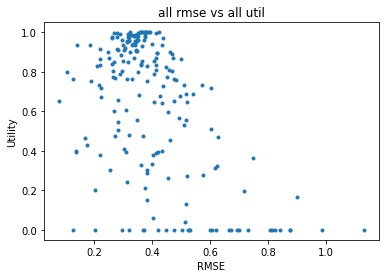

In [ ]:
plt.plot(hold_ens_RMSE, hold_ens_Utotal,'.')
plt.title('all rmse vs all util')
plt.xlabel('RMSE')
plt.ylabel('Utility')
# when would a bad fit (rmse=1) generate high utility?
# RMSE is a measure of the hindcast; utility is a measure of the forecast
# we 'flatten' utility, which might be causing the grouping in certain intervals

### This one: a large best-fit ensemble from a single truth model

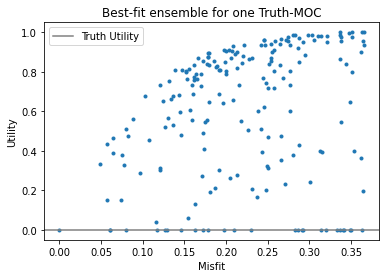

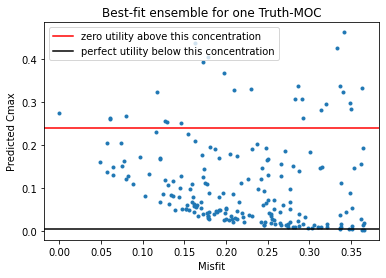

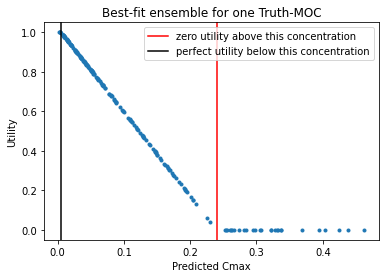

In [ ]:

plt.plot(ensemble.RMSE, ensemble.Utotal, '.')
h = truth_model.Utotal.to_numpy()
plt.axhline(y=h, color = 'gray', label = 'Truth Utility')
#plt.axvline(x=U_th, color = 'gray', label = 'Utility threshold')
plt.title('Best-fit ensemble for one Truth-MOC')
plt.xlabel('Misfit')
plt.ylabel('Utility')
plt.legend()
plt.show()
print()

plt.plot(ensemble.RMSE, ensemble.Cmax, '.')
plt.axhline(y=C_0, color = 'red', label = 'zero utility above this concentration')
plt.axhline(y=C_1, color = 'black', label = 'perfect utility below this concentration')
plt.title('Best-fit ensemble for one Truth-MOC')
plt.xlabel('Misfit')
plt.ylabel('Predicted Cmax')
plt.legend()
plt.show()
print()

plt.plot(ensemble.Cmax, ensemble.Utotal, '.')
plt.axvline(x=C_0, color = 'red', label = 'zero utility above this concentration')
plt.axvline(x=C_1, color = 'black', label = 'perfect utility below this concentration')
plt.title('Best-fit ensemble for one Truth-MOC')
plt.xlabel('Predicted Cmax')
plt.ylabel('Utility')
plt.legend()
plt.show()
print()

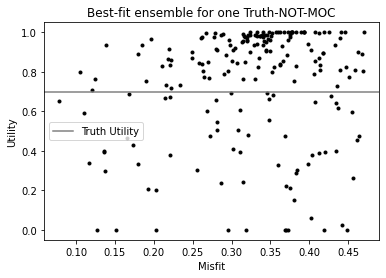

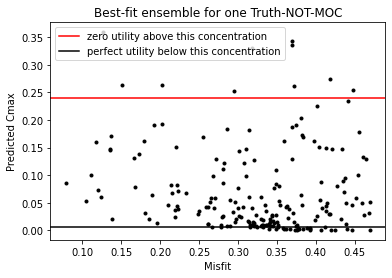

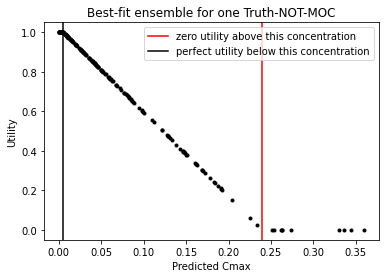

In [ ]:
plt.plot(ensemble.RMSE, ensemble.Utotal, '.', color='black')
h = truth_model.Utotal.to_numpy()
plt.axhline(y=h,color = 'gray', label = 'Truth Utility')
#plt.axvline(x=U_th, color = 'gray', label = 'Utility threshold')
plt.title('Best-fit ensemble for one Truth-NOT-MOC')
plt.xlabel('Misfit')
plt.ylabel('Utility')
plt.legend()
plt.show()
print()

plt.plot(ensemble.RMSE, ensemble.Cmax, '.', color='black')
plt.axhline(y=C_0, color = 'red', label = 'zero utility above this concentration')
plt.axhline(y=C_1, color = 'black', label = 'perfect utility below this concentration')
plt.title('Best-fit ensemble for one Truth-NOT-MOC')
plt.xlabel('Misfit')
plt.ylabel('Predicted Cmax')
plt.legend()
plt.show()
print()

plt.plot(ensemble.Cmax, ensemble.Utotal, '.', color='black')
plt.axvline(x=C_0, color = 'red', label = 'zero utility above this concentration')
plt.axvline(x=C_1, color = 'black', label = 'perfect utility below this concentration')
plt.title('Best-fit ensemble for one Truth-NOT-MOC')
plt.xlabel('Predicted Cmax')
plt.ylabel('Utility')
plt.legend()
plt.show()
print()

## To save and plot new run:

## To Read in csv of previous max_prob_df results





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# import csv to dataframe
max_probs_df = pd.read_csv('/content/drive/MyDrive/date_220509_FIVEHUNDO.csv')

# remove old index column
max_probs_df.drop(columns=max_probs_df.columns[0], axis = 1, inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set probability threshold

In [ ]:
prob_val = .515

### Plot R1 vs R1R2 

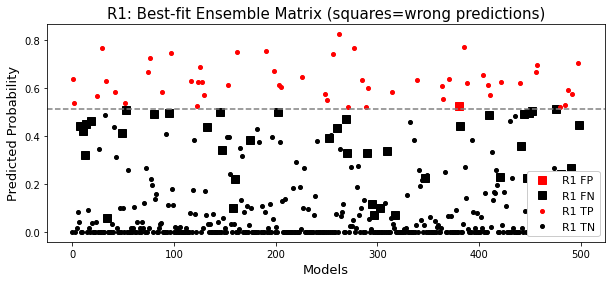

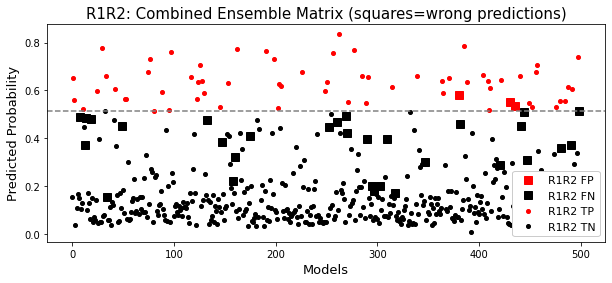

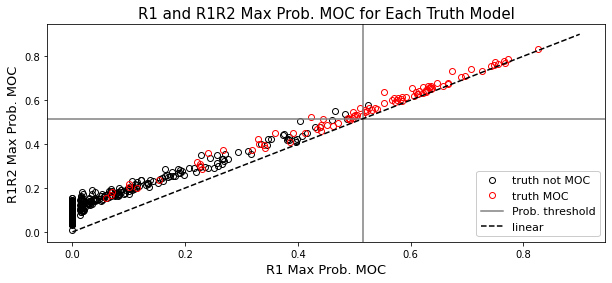

In [ ]:
# plot R1
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(max_probs_df.maxprob_R1[(max_probs_df.maxprob_R1 >= prob_val) & (max_probs_df.truth == 0)], 's', color='red', markersize=8,label='R1 FP')  #R1_FP
plt.plot(max_probs_df.maxprob_R1[(max_probs_df.maxprob_R1 <= prob_val) & (max_probs_df.truth == 1)], 's', color='black',markersize=8, label='R1 FN')  #R1_FN
plt.plot(max_probs_df.maxprob_R1[(max_probs_df.maxprob_R1 >= prob_val) & (max_probs_df.truth == 1)], '.', color='red', markersize=8,label='R1 TP')  #R1_TP
plt.plot(max_probs_df.maxprob_R1[(max_probs_df.maxprob_R1 <= prob_val) & (max_probs_df.truth == 0)], '.', color='black', markersize=8,label='R1 TN')  #R1_TN
plt.axhline(y=prob_val, linestyle = '--', color = 'gray')
plt.title("R1: Best-fit Ensemble Matrix (squares=wrong predictions)", fontsize=15)
plt.xlabel("Models", fontsize=13)
plt.ylabel("Predicted Probability",fontsize=13)
plt.legend(facecolor='white',framealpha=1,loc='lower right', fontsize=11)
plt.show()
print()

# plot R1R2
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(max_probs_df.maxprob_R1R2[(max_probs_df.maxprob_R1R2 >= prob_val) & (max_probs_df.truth == 0)], 's', color='red', markersize=8,label='R1R2 FP')  #R1R2_FP
plt.plot(max_probs_df.maxprob_R1R2[(max_probs_df.maxprob_R1R2 <= prob_val) & (max_probs_df.truth == 1)], 's', color='black',markersize=8, label='R1R2 FN')  #R1R2_FN
plt.plot(max_probs_df.maxprob_R1R2[(max_probs_df.maxprob_R1R2 >= prob_val) & (max_probs_df.truth == 1)], '.', color='red', markersize=8, label='R1R2 TP')  #R1R2_TP
plt.plot(max_probs_df.maxprob_R1R2[(max_probs_df.maxprob_R1R2 <= prob_val) & (max_probs_df.truth == 0)], '.', color='black',markersize=8, label='R1R2 TN')  #R1R2_TN
plt.axhline(y=prob_val, linestyle = '--', color = 'gray')
plt.title("R1R2: Combined Ensemble Matrix (squares=wrong predictions)", fontsize=15)
plt.xlabel("Models", fontsize=13)
plt.ylabel("Predicted Probability",fontsize=13)
plt.legend(facecolor='white',framealpha=1,loc='lower right', fontsize=11)
plt.show()
print()

##############################################################
#plot (R1, R1R2) for each truth model

plt.plot(max_probs_df.maxprob_R1[max_probs_df.truth==0], max_probs_df.maxprob_R1R2[max_probs_df.truth==0],
         '.',markerfacecolor = 'none', markersize = 12,color = 'black', label= 'truth not MOC')
plt.plot(max_probs_df.maxprob_R1[max_probs_df.truth==1], max_probs_df.maxprob_R1R2[max_probs_df.truth==1],
         '.', markerfacecolor = 'none',markersize = 12,color = 'red', label='truth MOC')

#plot probability thresholds
plt.axhline(y=prob_val, linestyle = '-', color = 'gray', label = 'Prob. threshold')
plt.axvline(x=prob_val, linestyle = '-', color = 'gray')

# fit linear trend line
#x1 = max_probs_df.maxprob_R1[max_probs_df.truth==1]
#y1 = max_probs_df.maxprob_R1R2[max_probs_df.truth==1]
#x2 = max_probs_df.maxprob_R1[max_probs_df.truth==0]
#y2 = max_probs_df.maxprob_R1R2[max_probs_df.truth==0]
# fit truth MOC
#z1 = np.polyfit(x1, y1, 1)
#p = np.poly1d(z1)
#plt.plot(x1,p(x1),"--", color = 'gray', label = 'indiv. trends')
# fit truth not MOC
#z2 = np.polyfit(x2, y2, 1)
#p = np.poly1d(z2)
#plt.plot(x2,p(x2),"--", color = 'gray')
# plot true linear trendline
abs_trend = np.arange(0,1,.1)
plt.plot(abs_trend, abs_trend, "--", color = 'black', label='linear')

plt.title("R1 and R1R2 Max Prob. MOC for Each Truth Model", fontsize=15)
plt.xlabel("R1 Max Prob. MOC", fontsize=13)
plt.ylabel("R1R2 Max Prob. MOC",fontsize=13)
plt.legend(facecolor='white',framealpha=1,loc='lower right', fontsize=11)
plt.show()

### Practice configuring the R1 v R1R2 plot

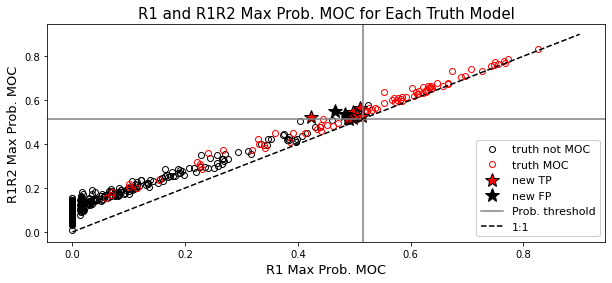

In [ ]:
#plot (R1, R1R2) for each truth model
# identify truth models where prediction moved from TN to FP
become_false_pos = max_probs_df[(max_probs_df.maxprob_R1 <= prob_val) & (max_probs_df.maxprob_R1R2 >= prob_val) & (max_probs_df.truth == 0)]
become_true_pos = max_probs_df[(max_probs_df.maxprob_R1 <= prob_val) & (max_probs_df.maxprob_R1R2 >= prob_val) & (max_probs_df.truth == 1)]

plt.plot(max_probs_df.maxprob_R1[max_probs_df.truth==0], max_probs_df.maxprob_R1R2[max_probs_df.truth==0],
         '.',markerfacecolor = 'none', markersize = 12,color = 'black', label= 'truth not MOC')
plt.plot(max_probs_df.maxprob_R1[max_probs_df.truth==1], max_probs_df.maxprob_R1R2[max_probs_df.truth==1],
         '.', markerfacecolor = 'none',markersize = 12,color = 'red', label='truth MOC')
plt.plot(become_true_pos.maxprob_R1, become_true_pos.maxprob_R1R2,
         '*', markerfacecolor = 'red', markersize=14, color = 'black', label = 'new TP')
plt.plot(become_false_pos.maxprob_R1, become_false_pos.maxprob_R1R2,
         '*', markerfacecolor = 'black', markersize=14, color = 'black', label = 'new FP')

#plot probability thresholds
plt.axhline(y=prob_val, linestyle = '-', color = 'gray', label = 'Prob. threshold')
plt.axvline(x=prob_val, linestyle = '-', color = 'gray')

# fit linear trend line
#x1 = max_probs_df.maxprob_R1[max_probs_df.truth==1]
#y1 = max_probs_df.maxprob_R1R2[max_probs_df.truth==1]
#x2 = max_probs_df.maxprob_R1[max_probs_df.truth==0]
#y2 = max_probs_df.maxprob_R1R2[max_probs_df.truth==0]
# fit truth MOC
#z1 = np.polyfit(x1, y1, 1)
#p = np.poly1d(z1)
#plt.plot(x1,p(x1),"--", color = 'gray', label = 'indiv. trends')
# fit truth not MOC
#z2 = np.polyfit(x2, y2, 1)
#p = np.poly1d(z2)
#plt.plot(x2,p(x2),"--", color = 'gray')
# plot true linear trendline
abs_trend = np.arange(0,1,.1)
plt.plot(abs_trend, abs_trend, "--", color = 'black', label='1:1')

plt.title("R1 and R1R2 Max Prob. MOC for Each Truth Model", fontsize=15)
plt.xlabel("R1 Max Prob. MOC", fontsize=13)
plt.ylabel("R1R2 Max Prob. MOC",fontsize=13)
plt.legend(facecolor='white',framealpha=1,loc='lower right', fontsize=11)
plt.show()

### Changed models only

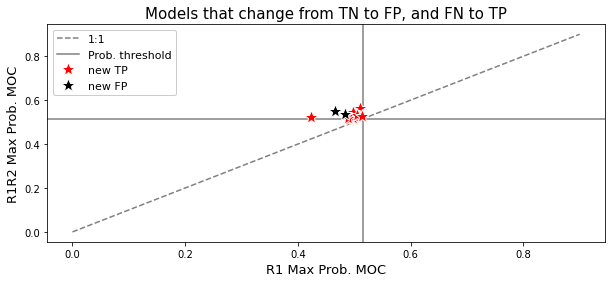

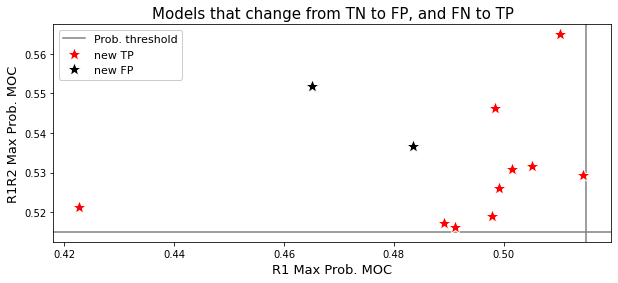

In [ ]:
#plot probability thresholds
abs_trend = np.arange(0,1,.1)
plt.plot(abs_trend, abs_trend, "--", color = 'gray', label='1:1')
plt.axhline(y=prob_val, linestyle = '-', color = 'gray', label = 'Prob. threshold')
plt.axvline(x=prob_val, linestyle = '-', color = 'gray')

plt.plot(become_true_pos.maxprob_R1, become_true_pos.maxprob_R1R2,
         '*', markerfacecolor = 'red', markersize=14, color = 'white', label = 'new TP')
plt.plot(become_false_pos.maxprob_R1, become_false_pos.maxprob_R1R2,
         '*', markerfacecolor = 'black', markersize=14, color = 'white', label = 'new FP')

plt.title("Models that change from TN to FP, and FN to TP", fontsize=15)
plt.xlabel("R1 Max Prob. MOC", fontsize=13)
plt.ylabel("R1R2 Max Prob. MOC",fontsize=13)
plt.legend(facecolor='white',framealpha=1,loc='upper left', fontsize=11)
plt.show()

######################################################################
# Zoom in plot
#plot probability thresholds
plt.axhline(y=prob_val, linestyle = '-', color = 'gray', label = 'Prob. threshold')
plt.axvline(x=prob_val, linestyle = '-', color = 'gray')

plt.plot(become_true_pos.maxprob_R1, become_true_pos.maxprob_R1R2,
         '*', markerfacecolor = 'red', markersize=14, color = 'white', label = 'new TP')
plt.plot(become_false_pos.maxprob_R1, become_false_pos.maxprob_R1R2,
         '*', markerfacecolor = 'black', markersize=14, color = 'white', label = 'new FP')

plt.title("Models that change from TN to FP, and FN to TP", fontsize=15)
plt.xlabel("R1 Max Prob. MOC", fontsize=13)
plt.ylabel("R1R2 Max Prob. MOC",fontsize=13)
plt.legend(facecolor='white',framealpha=1,loc='upper left', fontsize=11)
plt.show()

### Quadrant III

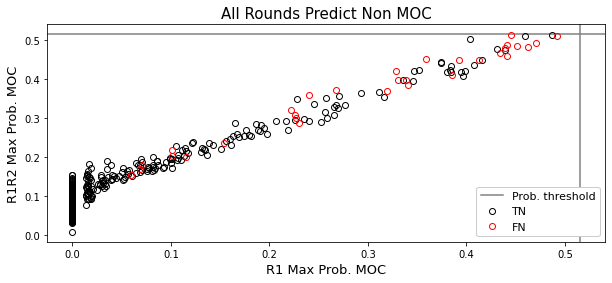

In [ ]:
# identify truth models where neither round predicted MOC
quad3 = max_probs_df[(max_probs_df.maxprob_R1 <= prob_val) & (max_probs_df.maxprob_R1R2 <= prob_val)]

#plot probability thresholds
plt.axhline(y=prob_val, linestyle = '-', color = 'gray', label = 'Prob. threshold')
plt.axvline(x=prob_val, linestyle = '-', color = 'gray')

#plot (R1, R1R2) for each truth model
plt.plot(quad3.maxprob_R1[quad3.truth==0], quad3.maxprob_R1R2[quad3.truth==0],
         '.',markerfacecolor = 'none', markersize = 12,color = 'black', label= 'TN')
plt.plot(quad3.maxprob_R1[quad3.truth==1], quad3.maxprob_R1R2[quad3.truth==1],
         '.', markerfacecolor = 'none',markersize = 12,color = 'red', label='FN')

plt.title("All Rounds Predict Non MOC", fontsize=15)
plt.xlabel("R1 Max Prob. MOC", fontsize=13)
plt.ylabel("R1R2 Max Prob. MOC",fontsize=13)
plt.legend(facecolor='white',framealpha=1,loc='lower right', fontsize=11)
plt.show()